# **Vanilla RNN on timeseries**

### **imports**

In [1]:
import numpy as np
import numpy.random as rnd
import itertools 
import os
import sys
import scipy.misc
import random

# We used some utilities from sklearn
from sklearn.preprocessing import StandardScaler

#PyTorch
import torch
from torch import nn
from torch.optim import Adam, SGD
from torchinfo import summary
from torch.autograd  import Variable

# Used for plotting and display of figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12


from IPython.display import display
from IPython.display import Image
from IPython.display import SVG

### **importing dataset**

In [2]:
import pandas as pd
df = pd.read_csv('data_akbilgic.csv')


In [3]:
df.head()

,date,ISE,ISE.1,SP,DAX,FTSE,NIKKEI,BOVESPA,EU,EM
0,5-Jan-09,0.035754,0.038376,-0.004679,0.002193,0.003894,0.000000,0.031190,0.012698,0.028524
1,6-Jan-09,0.025426,0.031813,0.007787,0.008455,0.012866,0.004162,0.018920,0.011341,0.008773
2,7-Jan-09,-0.028862,-0.026353,-0.030469,-0.017833,-0.028735,0.017293,-0.035899,-0.017073,-0.020015
3,8-Jan-09,-0.062208,-0.084716,0.003391,-0.011726,-0.000466,-0.040061,0.028283,-0.005561,-0.019424
4,9-Jan-09,0.009860,0.009658,-0.021533,-0.019873,-0.012710,-0.004474,-0.009764,-0.010989,-0.007802


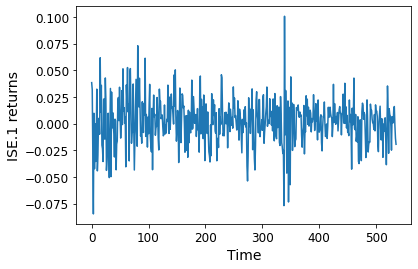

In [4]:
plt.plot(df['ISE.1'])
plt.xlabel("Time")
plt.ylabel("ISE.1 returns")
plt.show()

### **splitting the data - test/train**

In [5]:
#main dataset,ratio -> train,test
def split(df,train_size=0.8):
    size = df.shape[0]
    train_set_size = int(size*train_size)
    #chosing desired columns
    df_train = df.iloc[:train_set_size,2:-1]
    df_test = df.iloc[train_set_size:,2:-1]
    return df_train,df_test

In [6]:
df_train,df_test = split(df)
df_train,df_test = split(df,train_size=0.8)
print(f'data set samples:\t {df.shape[0]}\ntrainset samples:\t {df_train.shape[0]} \ntestset samples:\t {df_test.shape[0]}')


data set samples:	 536
trainset samples:	 428 
testset samples:	 108


### **batchifying**

**helper func.-timeseries**

In [7]:
#dataset, steps -> timeseries x(steps,features) concatenated to y(steps,)
def timeseries(df,step):
    rows,columns = df.shape
    result =[]
    x = None
    y = None
    result = []
    j=0
    # i is the ending limit for moving box
    for i in range(step+1,rows,step+1):
        #casting desired sub set into array
        x = df.iloc[j:j+step,:].values
        #updating starting point
        #getting label
        y = df.iloc[j+1:j+step+1,0].values
        j=i
        result.append(np.append(x,y.reshape(-1,1),axis=1))
    return np.array(result)

**TensorDataset**

In [8]:
from torch.utils.data import TensorDataset,DataLoader
def dataload(batch_size,n_steps,df_base):
    data = timeseries(df_base,n_steps)
    x = data[:,:,:-1]
    y = data[:,:,-1]
    x,y = torch.tensor(x,dtype=torch.float32),torch.tensor(y,dtype=torch.float32)
    #generates dataset from tensors
    dataset = TensorDataset(x,y)
    #contructs dataloader
    loader = DataLoader(dataset,batch_size=batch_size,shuffle=False)
    return loader

In [9]:
loader = dataload(batch_size=1,n_steps=4,df_base=df_train)

### **Parameters**

In [10]:
# An RNN can take as inputs multiple input sequences (e.g, a matrix of n_seq x n_steps)
# Since we use only a single TS, n_inputs=1
n_inputs = 7


# n_steps is the size of the contiguous sequence that is taken from the TS
# it coincides with the number of time steps for the RNN
n_steps = 6

# An RNN can take as inputs multiple input sequences (e.g, a matrix of n_seq x n_steps)
n_inputs = 7

# There is one layer of X recurrent neurons together
n_neurons = 50

# The ouput will be a single sequence
n_outputs = 1

### **Constructing a model**

In [11]:
class Model(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers, n_steps):
        super(Model, self).__init__()

        # Defining some parameters
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.hidden = [0]
        #Defining the layers
        # RNN Layer
        self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim,output_size)
    
    def forward(self, x):
        
        # complete the forward function so it returns the output and the last hidden state
        # what is the input of an RNN?
        if len(self.hidden) == 1:
            h0 = self.init_hidden(x.size(0))
            h0 = h0.requires_grad_()
            
        out,hidd = self.rnn(x,h0) #size of output -> batch_size x seq_size x hidden size

        out = out[:,-1,:] #we take only the last sequence output, so , batch_size x 1 x hidden_size
        out = self.fc(out)
        return out,hidd
    
    def init_hidden(self, batch_size):
        # This method generates the first hidden state of zeros which we'll use in the forward pass
        # We'll send the tensor holding the hidden state to the device we specified earlier as well
        hidden = torch.zeros(self.n_layers,batch_size,self.hidden_dim)
        return hidden

### **Criterion and Optimizer**

In [12]:
# We initialize our RNN model to pass it to the optimizer

model = Model(7,1,50,1,6)

# What would be an adecuate loss function?
criterion =  nn.MSELoss()

# optimizer to apply the gradients
optim = Adam(model.parameters(),lr=0.03)



/Users/saidalikhonalikhonov/opt/anaconda3/envs/deep_env/lib/python3.9/site-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([1, 6])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


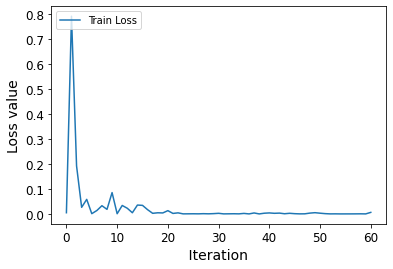

In [13]:
loader = dataload(1,6,df_train)
#number of batches we will go through
n_iterations = len(loader)

# #how many squence there will be in a bacth
batch_size = 6
#after how many operations we will print information
printing_gap = 2

#We will store the loss values here to plot them
train_loss = []


train_loss = []
# for iter in range(n_iterations):
for batch,labels in loader:
    
    #Reset the gradients
    optim.zero_grad()
    #Get the outputs
    out,hidd = model.forward(batch)
    #detach the hidden state
    hidd = hidd.detach_()
    #compute the loss
    loss = criterion(out,labels)
    #compute the gradients
    loss.backward()
    #Apply the gradients
    optim.step()

    #Append the loss value
    train_loss.append(loss.item())

    # if iter % printing_gap == 0:
    #     pass
    #     #Print the information


plt.plot(train_loss, label= "Train Loss")
plt.xlabel(" Iteration ")
plt.ylabel("Loss value")
plt.legend(loc="upper left")
plt.show()




### **testing**

In [21]:
testload = dataload(2,5,df_test)

In [22]:
x,y = iter(testload).next()

In [23]:
with torch.no_grad():
    model.eval()
    pred_test,hidden = model.forward(x)
    loss = criterion(pred_test,y)

/Users/saidalikhonalikhonov/opt/anaconda3/envs/deep_env/lib/python3.9/site-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([2, 5])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [24]:
pred_test


tensor([[-0.0182],
        [-0.0250]])

In [25]:
y

tensor([[-0.0007,  0.0066,  0.0003,  0.0104, -0.0069],
        [ 0.0128,  0.0159,  0.0102,  0.0088, -0.0106]])